# Day 7: Week 5.1 Review - Linear Models Interview Prep

## 🎯 Learning Objectives
- Consolidate all linear regression methods
- Build production-ready model selection pipeline
- Practice interview questions
- Final comprehensive trading strategy

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | OLS | Baseline, assumptions, diagnostics |
| 2 | Ridge | L2 regularization, multicollinearity |
| 3 | Lasso | L1 regularization, feature selection |
| 4 | Elastic Net | L1+L2, grouped selection |
| 5 | Cross-Sectional | Fama-MacBeth, factor premia |
| 6 | WLS/Robust | Heteroscedasticity, outliers |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, 
                                   ElasticNet, ElasticNetCV, HuberRegressor)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'GS', 'SPY', 'QQQ']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days")

📥 Downloading data...
✅ Data: 1255 days


In [2]:
# Comprehensive Feature Engineering
target = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Momentum
for lag in [1, 5, 10, 20, 60]:
    df[f'mom_{lag}d'] = prices[target].pct_change(lag)

# Volatility
for window in [5, 10, 20, 60]:
    df[f'vol_{window}d'] = returns[target].rolling(window).std()

# Moving Averages
for window in [10, 20, 50]:
    df[f'ma_ratio_{window}'] = prices[target] / prices[target].rolling(window).mean() - 1

# Market features
df['spy_return'] = returns['SPY']
df['qqq_return'] = returns['QQQ']
df['market_vol'] = returns['SPY'].rolling(20).std()

# Relative strength
df['rel_strength_spy'] = returns[target].rolling(20).mean() - returns['SPY'].rolling(20).mean()

# Target
df['target'] = returns[target].shift(-1)
df = df.dropna()

print(f"📊 Features: {len(df.columns)-1}")

📊 Features: 16


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c != 'target']
X = df[feature_cols]
y = df['target']

# Time-series split
split_idx = int(len(df) * 0.7)
val_idx = int(len(df) * 0.85)

X_train = X.iloc[:split_idx]
X_val = X.iloc[split_idx:val_idx]
X_test = X.iloc[val_idx:]

y_train = y.iloc[:split_idx]
y_val = y.iloc[split_idx:val_idx]
y_test = y.iloc[val_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 836, Val: 179, Test: 180


In [4]:
# Model Selection Pipeline
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'OLS': LinearRegression(),
    'Ridge': RidgeCV(alphas=np.logspace(-3, 3, 100), cv=tscv),
    'Lasso': LassoCV(alphas=np.logspace(-5, -1, 100), cv=tscv, max_iter=10000),
    'ElasticNet': ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.99], 
                               alphas=np.logspace(-5, -1, 50), cv=tscv, max_iter=10000),
    'Huber': HuberRegressor(epsilon=1.35, max_iter=1000)
}

# Train all models
print("\n" + "="*60)
print("TRAINING ALL LINEAR MODELS")
print("="*60)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"✅ {name} trained")


TRAINING ALL LINEAR MODELS
✅ OLS trained
✅ Ridge trained
✅ Lasso trained
✅ ElasticNet trained
✅ Huber trained


In [5]:
# Validation Set Performance
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

val_results = []
val_predictions = {}

for name, model in models.items():
    pred = model.predict(X_val_scaled)
    val_predictions[name] = pred
    
    val_results.append({
        'Model': name,
        'R²': r2_score(y_val, pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, pred)),
        'MAE': mean_absolute_error(y_val, pred),
        'Dir. Acc.': (np.sign(pred) == np.sign(y_val)).mean(),
        '# Features': np.sum(model.coef_ != 0) if hasattr(model, 'coef_') else len(feature_cols)
    })

val_df = pd.DataFrame(val_results)
print(val_df.to_string(index=False))

# Select best model based on directional accuracy
best_model_name = val_df.loc[val_df['Dir. Acc.'].idxmax(), 'Model']
print(f"\n🏆 Best Model (by Dir. Accuracy): {best_model_name}")


VALIDATION SET PERFORMANCE
     Model        R²     RMSE      MAE  Dir. Acc.  # Features
       OLS -0.006024 0.021754 0.013825   0.486034          16
     Ridge -0.002764 0.021719 0.013532   0.536313          16
     Lasso -0.003473 0.021727 0.013490   0.536313           0
ElasticNet -0.003473 0.021727 0.013490   0.536313           0
     Huber -0.013443 0.021834 0.013779   0.480447          16

🏆 Best Model (by Dir. Accuracy): Ridge


In [6]:
# Test Set Performance (Final Evaluation)
print("\n" + "="*70)
print("TEST SET PERFORMANCE (Out-of-Sample)")
print("="*70)

test_results = []
test_predictions = {}

for name, model in models.items():
    pred = model.predict(X_test_scaled)
    test_predictions[name] = pred
    
    test_results.append({
        'Model': name,
        'R²': r2_score(y_test, pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'Dir. Acc.': (np.sign(pred) == np.sign(y_test)).mean()
    })

test_df = pd.DataFrame(test_results)
print(test_df.to_string(index=False))


TEST SET PERFORMANCE (Out-of-Sample)
     Model        R²     RMSE      MAE  Dir. Acc.
       OLS -0.031600 0.014079 0.009692   0.516667
     Ridge -0.009522 0.013928 0.009545   0.511111
     Lasso -0.001604 0.013873 0.009510   0.522222
ElasticNet -0.001604 0.013873 0.009510   0.522222
     Huber -0.028096 0.014055 0.009672   0.516667


In [7]:
# Ensemble Model (Average of all predictions)
ensemble_pred = np.mean([test_predictions[name] for name in models.keys()], axis=0)

print("\n" + "="*60)
print("ENSEMBLE MODEL PERFORMANCE")
print("="*60)
print(f"R²: {r2_score(y_test, ensemble_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ensemble_pred)):.6f}")
print(f"Dir. Acc.: {(np.sign(ensemble_pred) == np.sign(y_test)).mean():.2%}")


ENSEMBLE MODEL PERFORMANCE
R²: -0.0094
RMSE: 0.013927
Dir. Acc.: 51.67%


In [8]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual'] = y_test.values

# Individual models
for name, pred in test_predictions.items():
    backtest[f'{name}_signal'] = np.where(pred > 0, 1, 0)
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual']

# Ensemble
backtest['Ensemble_signal'] = np.where(ensemble_pred > 0, 1, 0)
backtest['Ensemble_return'] = backtest['Ensemble_signal'] * backtest['actual']

# Buy and hold
backtest['buy_hold_return'] = backtest['actual']

# Cumulative returns
strategies = list(models.keys()) + ['Ensemble', 'buy_hold']
for strat in strategies:
    if strat == 'buy_hold':
        backtest[f'{strat}_cum'] = (1 + backtest['actual']).cumprod()
    else:
        backtest[f'{strat}_cum'] = (1 + backtest[f'{strat}_return']).cumprod()

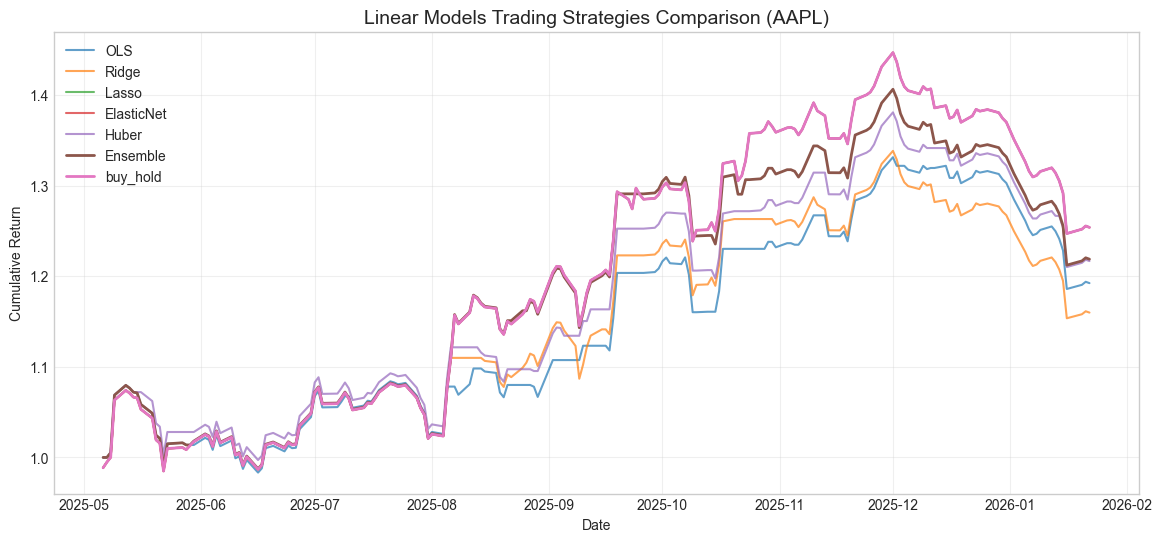

In [9]:
# Plot results
plt.figure(figsize=(14, 6))
for strat in strategies:
    plt.plot(backtest.index, backtest[f'{strat}_cum'], 
             label=strat, linewidth=2 if strat in ['Ensemble', 'buy_hold'] else 1.5,
             alpha=1.0 if strat in ['Ensemble', 'buy_hold'] else 0.7)

plt.title(f'Linear Models Trading Strategies Comparison ({target})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Final Performance Summary
def calc_metrics(returns, cumulative):
    total_ret = cumulative.iloc[-1] - 1
    ann_ret = returns.mean() * TRADING_DAYS
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0
    
    peak = cumulative.cummax()
    dd = (cumulative - peak) / peak
    max_dd = dd.min()
    
    return total_ret, sharpe, max_dd

print("\n" + "="*70)
print("FINAL STRATEGY PERFORMANCE SUMMARY")
print("="*70)

print(f"\n{'Strategy':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)

for strat in strategies:
    ret_col = 'actual' if strat == 'buy_hold' else f'{strat}_return'
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[f'{strat}_cum'])
    print(f"{strat:<15} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


FINAL STRATEGY PERFORMANCE SUMMARY

Strategy           Total Ret     Sharpe     Max DD
--------------------------------------------------
OLS                   19.23%       1.10    -10.92%
Ridge                 15.98%       0.86    -13.80%
Lasso                 25.38%       1.32    -13.80%
ElasticNet            25.38%       1.32    -13.80%
Huber                 21.66%       1.23    -12.36%
Ensemble              21.87%       1.16    -13.80%
buy_hold              25.38%       1.32    -13.80%


In [11]:
# Feature Importance (from Elastic Net)
en_model = models['ElasticNet']
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': en_model.coef_,
    'Abs_Coef': np.abs(en_model.coef_)
}).sort_values('Abs_Coef', ascending=False)

# Show non-zero features
selected = feature_importance[feature_importance['Coefficient'] != 0]

print("\n" + "="*60)
print("ELASTIC NET SELECTED FEATURES")
print("="*60)
for i, row in selected.head(10).iterrows():
    direction = "📈" if row['Coefficient'] > 0 else "📉"
    print(f"{row['Feature']:<25} {row['Coefficient']:>12.6f} {direction}")


ELASTIC NET SELECTED FEATURES


In [12]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {target}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

predictions = []
for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    predictions.append(pred)
    signal = '📈 LONG' if pred > 0 else '📉 OUT'
    print(f"{name:<15}: {pred:>10.4%} → {signal}")

# Ensemble
ensemble = np.mean(predictions)
print(f"{'ENSEMBLE':<15}: {ensemble:>10.4%} → {'📈 LONG' if ensemble > 0 else '📉 OUT'}")

# Consensus
bullish = sum(1 for p in predictions if p > 0)
print(f"\n🎯 Model Consensus: {bullish}/{len(predictions)} bullish")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-22
OLS            :    0.1082% → 📈 LONG
Ridge          :    0.1613% → 📈 LONG
Lasso          :    0.0797% → 📈 LONG
ElasticNet     :    0.0797% → 📈 LONG
Huber          :    0.1977% → 📈 LONG
ENSEMBLE       :    0.1253% → 📈 LONG

🎯 Model Consensus: 5/5 bullish


---

## 📝 Interview Questions & Answers

### Q1: When would you use Ridge vs Lasso?
**A:** Ridge when features are correlated and you want to keep all of them (shrink, not select). Lasso when you want automatic feature selection or believe many features are irrelevant.

### Q2: Why is R² often low in return prediction?
**A:** Returns are largely unpredictable (Efficient Market Hypothesis). R² of 0.01-0.05 can still be economically significant and profitable.

### Q3: What's the problem with OLS for financial data?
**A:** Heteroscedasticity (volatility clustering), fat tails, autocorrelation in volatility. Solutions: WLS, robust standard errors, GARCH.

### Q4: Explain the bias-variance tradeoff in regularization.
**A:** Higher lambda → more bias, less variance. Lower lambda → less bias, more variance. Optimal lambda minimizes test error.

### Q5: Why use cross-sectional regression in factor models?
**A:** To estimate factor risk premia and identify which factors are priced. Fama-MacBeth accounts for cross-sectional correlation.

---

## 🏢 Company Use Cases

| Company | Linear Model Application |
|---------|-------------------------|
| AQR | Factor model estimation (Ridge/Lasso) |
| Two Sigma | High-dimensional alpha modeling (Elastic Net) |
| BlackRock | Risk factor exposure (OLS with Newey-West) |
| Citadel | Cross-sectional stock selection (Fama-MacBeth) |
| D.E. Shaw | Robust regression for outlier handling |

---

## 📅 Next Week: Classification Methods (Logistic, SVM, Triple-Barrier)